<a href="https://colab.research.google.com/github/abelowska/eegML/blob/main/Classes_03_simple_regression_on_perfectionism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of perfectionism CMDA subscale from error-related negativity ERP component

Install additional libraries

In [ ]:
!pip install MNE

Imports

In [2]:
import os
import re
import glob
import os
import sys
import ast
import os.path as op
from collections import defaultdict
from copy import deepcopy
import copy

import pickle
import mne
import scipy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

## Mount data

In [3]:
# constants
tmin, tmax = -0.101562, 0.5937525  # Start and end of the segments
signal_frequency = 256
random_state = 42
test_size = 0.3

ERROR = 1
CORRECT = 0

In [4]:
# mount google drive in colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


To have an access to the shared folder on Google Drive you have to add shortcut to shared folder straightly to your "My drive". When you add this shortcut, folder *perfectionism_data* sholud be visible.

In [5]:
# display data in folder
!ls gdrive/MyDrive/perfectionism_data

GNG_perfectionism.pkl  picked  responses_100_600.zip  scales


In [ ]:
# unzip and load eeg data
!unzip gdrive/MyDrive/perfectionism_data/responses_100_600.zip

## Basic use of the [MNE](https://mne.tools/stable/index.html) library

MNE-Python data structures are based around the FIF file format from Neuromag, but there are reader functions for a wide [variety of other data formats](https://mne.tools/stable/overview/implementation.html#data-formats). Data is loaded into so-called [Raw](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw) object.

Load data into raw object

In [13]:
file_name = "responses_100_600/GNG_AA0303-64 el.vhdr"
raw = mne.io.read_raw_brainvision(file_name)

Extracting parameters from responses_100_600/GNG_AA0303-64 el.vhdr...
Setting channel info structure...


You can get a glimpse of the basic details of a Raw object by printing it; even more is available by printing its info attribute (a dictionary-like object that is preserved across Raw, Epochs, and Evoked objects). The info data structure keeps track of channel locations, applied filters, projectors, etc. Notice especially the chs entry, showing that MNE-Python detects different sensor types and handles each appropriately. See The Info data structure for more on the Info class.

In [14]:
print(raw)
print(raw.info)

<RawBrainVision | GNG_AA0303-64 el.dat, 64 x 55669 (217.5 s), ~96 kB, data not loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2019-05-25 15:41:48 UTC
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>


Using matplotlib as 2D backend.


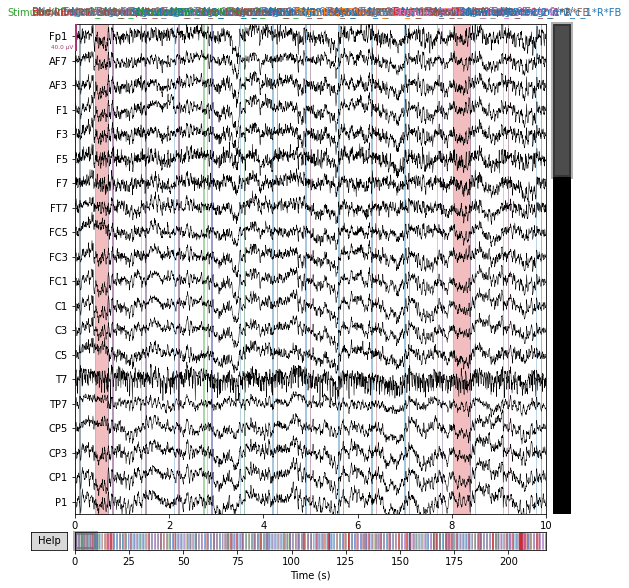

In [10]:
fig = raw.plot()

On the plot, we see the raw EEG signal with bad signal fragments highlighted in red. These markings are from an automatic procedure with a rejection criterion of ±65 µV in a ± 200 ms time window done in Brain Vison Analyser. 

We can also see the triggers(events) marked with vertical colored lines.

**Annotations**

[Annotations](https://mne.tools/stable/generated/mne.Annotations.html) in MNE-Python are a way of storing short strings of information about temporal spans of a Raw object. Below the surface, Annotations are list-like objects, where each element comprises three pieces of information: an onset time (in seconds), a duration (also in seconds), and a description (a text string). Additionally, the Annotations object itself also keeps track of orig_time, which is a POSIX timestamp denoting a real-world time relative to which the annotation onsets should be interpreted.

In [11]:
annot_file = file_name[:-4] + "vmrk"

# Read in the event information as MNE annotations
annotations = mne.read_annotations(annot_file)
annotations

Finding 'sfreq' from header file: /content/responses_100_600/GNG_AA0303-64 el.vhdr


<Annotations | 1095 segments: Bad Interval/Bad Amplitude (141), New ...>

Add the annotations to our raw object so we can use them with the data


In [16]:
raw.set_annotations(annotations)

<RawBrainVision | GNG_AA0303-64 el.dat, 64 x 55669 (217.5 s), ~96 kB, data not loaded>

In general, annotations store information about [Events](https://mne.tools/dev/events.html#events) that occurred and were encoded during EEG recording. Such events could be a keystroke, the appearance of a target, feedback, etc. 

We can preview events and their timing: 

In [18]:
# extract events
events, event_ids = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/CU*ex*1_n*1_c_1*R*FB', 'Stimulus/FB*ex*1_n*1_c_1*R', 'Stimulus/FB*ex*2_n*2_c_1*R', 'Stimulus/RE*ex*1_n*1_c_1*R*FB', 'Stimulus/RE*ex*1_n*1_c_1*R*FG', 'Stimulus/RE*ex*1_n*1_c_2*R', 'Stimulus/RE*ex*1_n*2_c_1*R', 'Stimulus/RE*ex*2_n*1_c_1*R', 'Stimulus/RE*ex*2_n*2_c_1*R*FB', 'Stimulus/RE*ex*2_n*2_c_1*R*FG', 'Stimulus/RE*ex*2_n*2_c_2*R', 'Time 0/']


In [19]:
# display events names
event_ids

{'New Segment/': 99999,
 'Stimulus/CU*ex*1_n*1_c_1*R*FB': 10001,
 'Stimulus/FB*ex*1_n*1_c_1*R': 10002,
 'Stimulus/FB*ex*2_n*2_c_1*R': 10003,
 'Stimulus/RE*ex*1_n*1_c_1*R*FB': 10004,
 'Stimulus/RE*ex*1_n*1_c_1*R*FG': 10005,
 'Stimulus/RE*ex*1_n*1_c_2*R': 10006,
 'Stimulus/RE*ex*1_n*2_c_1*R': 10007,
 'Stimulus/RE*ex*2_n*1_c_1*R': 10008,
 'Stimulus/RE*ex*2_n*2_c_1*R*FB': 10009,
 'Stimulus/RE*ex*2_n*2_c_1*R*FG': 10010,
 'Stimulus/RE*ex*2_n*2_c_2*R': 10011,
 'Time 0/': 10012}

Event ids are defined as a dictionary of names and their codes, as we can see above.

The resulting events array is an ordinary 3-column NumPy array, with sample number in the first column and integer event ID in the last column; the middle column is usually ignored.

In [23]:
# display events
events

array([[    0,     0, 99999],
       [   26,     0, 10011],
       [   26,     0, 10012],
       ...,
       [55490,     0, 99999],
       [55516,     0, 10012],
       [55516,     0, 10009]])

Working with the raw data, we can plot the subset of the signal. Again, we can see events marked with coloured vertical lines and EEG signal on 64 electrodes.

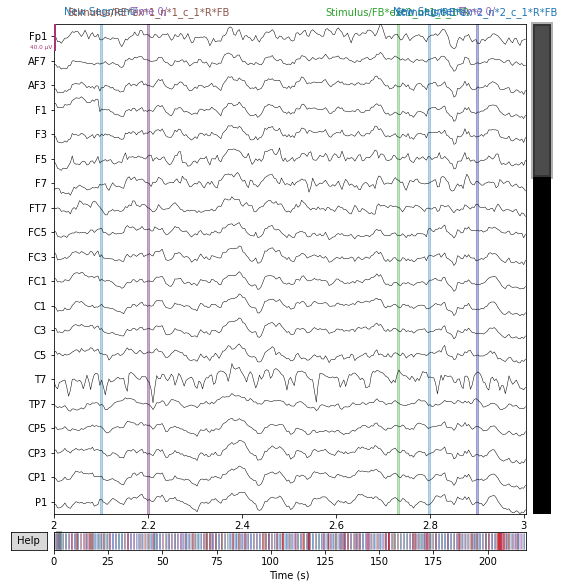

In [31]:
fig = raw.plot(start=2, duration=1, show=False)
plt.show()

Event dictionaries can be used to extract only events of interest. In this case, we define a dictionary that consists of events of interest and then extract only those events from Annotations:

In [33]:
event_dict = {'Stimulus/FB*ex*2_n*2_c_1*R': 10003}
events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

Used Annotations descriptions: ['Stimulus/FB*ex*2_n*2_c_1*R']


The Raw object and the events array are the bare minimum needed to create an [Epochs](https://mne.tools/stable/generated/mne.Epochs.html#mne.Epochs) object, which we create with the Epochs class constructor.

We’ll also pass the event dictionary as the event_id parameter (so we can work with easy-to-pool event labels instead of the integer event IDs), and specify tmin and tmax (the time relative to each event at which to start and end each epoch). By default Raw and Epochs data aren’t loaded into memory (they’re accessed from disk only when needed), but here we’ll force loading into memory using the `preload=True`.

In [35]:
epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=event_ids,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=True,
        preload=True,
    )

Not setting metadata
12 matching events found
No baseline correction applied
0 projection items activated
Loading data for 12 events and 179 original time points ...
7 bad epochs dropped


Again, we can print the basic details of Epoch object.

In [38]:
print(epochs)
print(epochs.info)

<Epochs |  5 events (all good), -0.101562 - 0.59375 sec, baseline off, ~544 kB, data loaded,
 'Stimulus/FB*ex*2_n*2_c_1*R': 5>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2019-05-25 15:41:48 UTC
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>


Like Raw objects, Epochs objects also have a number of built-in plotting methods. One is plot_image, which shows each epoch as one row of an image map, with color representing signal magnitude; the average evoked response and the sensor location are shown below the image:

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated


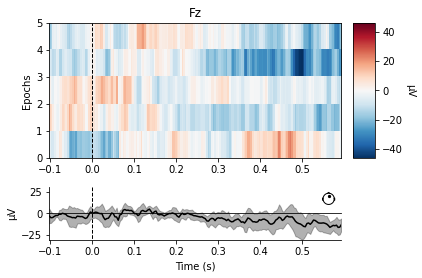

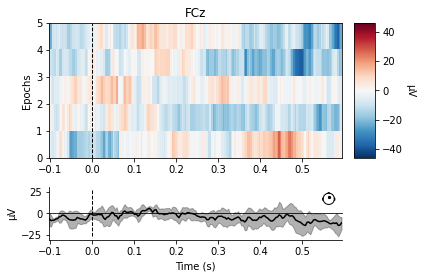

In [40]:
fig = epochs.plot_image(picks=['Fz', 'FCz'])

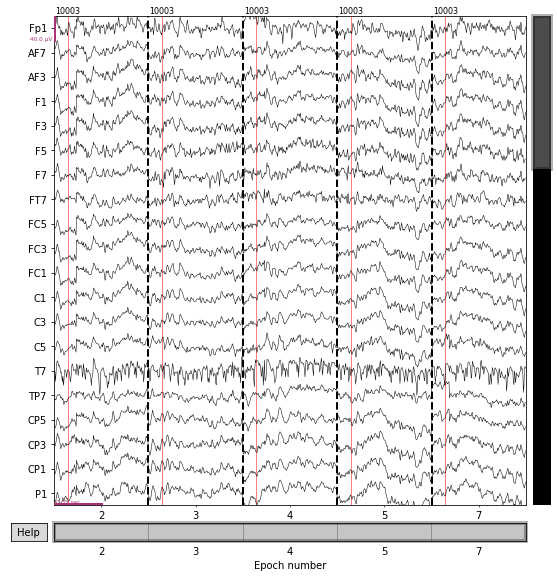

In [ ]:
fig = epochs.plot(events=events, event_color='r')

MNE-Python offers a huge number of tools for working on EEG signals. It also has great [tutorials](https://mne.tools/stable/auto_tutorials/index.html) and [examples](https://mne.tools/stable/auto_examples/index.html). I strongly encourage you to familiarize yourself with them.

---
## Loading data

Loading EEG and questionnaire data. By default create_df_data loads all info from given .csv file but one can specify it by passing a list of desired labels.

In [ ]:
def create_df_data(
    dir_path,
    info_filename=None,
    info="all",
):
    """Loads data for all participants and creates DataFrame with optional additional info from given .csv file.

    Parameters
    ----------
    dir_path: String
        path to the directory TODO
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(dir_path)
    header_files_glob = "responses_100_600/*.vhdr"
    print(header_files_glob)

    # extract header files
    header_files = glob.glob(header_files_glob)
    header_files = sorted(header_files)
    print(header_files)

    # create dataframe for results
    go_nogo_data_df = pd.DataFrame()

    for file in header_files:
        # load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )

        # add participant's data to results dataframe
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [ ]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }
    correct_response_event_ids = [10004, 10005, 10009, 10010]
    error_response_event_ids = [10006, 10007, 10008, 10011]

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct events of interest from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        correct_response_event_ids,
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        error_response_event_ids,
        merged_event_dict["error_response"],
        replace_events=True,
    )

    # epochs = []
    this_reject_by_annotation = True

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    return epochs

In [ ]:
def create_df_from_epochs(
    id, 
    participant_epochs, 
    info_filename, 
    info
):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    participant_epochs: mne Epochs
        epoched eeg data
    info_filename: String
        path to .csv file with questionnaire data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """

    # create dataframe for participant's questionnaire data
    info_df = pd.DataFrame()

    # extract questionnaire data from .csv file
    if info_filename is not None:
        if info == "all":
            this_info_df = pd.read_csv(info_filename)
        else:
            this_info_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            this_info_df.loc[this_info_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )
        
    # create dataframe record with participant's data: ID, eeg data, questionnaire data    
    participant_df = pd.DataFrame(
        {
            "id": [id], 
            "epoch": [participant_epochs], 
        }).join(
            info_df
        )

    return participant_df

### Read data

In [45]:
# paths to data
dir_path = "gdrive/MyDrive/perfectionism_data/"
questionnaire_filename = dir_path + "scales/perfectionism_data.csv"

# define dataframe name 
df_name = "GNG_perfectionism"

# check whether pickled data exists
pickled_data_filename = dir_path + df_name + ".pkl"

if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        dir_path = dir_path,
        info_filename=questionnaire_filename,
        info="all"
    )

    epochs_df.name = df_name
    
    # save loaded data into a pickle file
    epochs_df.to_pickle(dir_path + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [ ]:
print(epochs_df.shape)
epochs_df.head()

(138, 11)


,id,epoch,Demo_kod,17-Perfect CM-Concern over Mistakes (9 items mean),17-Perfect PS-Personal Standards (7 items mean),17-Perfect PE-Parental Expectations (5 items mean),17-Perfect PC=Parental Criticism (4 items mean),17-Perfect D=Doubts about Actions (4 items mean),17-Perfect O=Organization (6 items mean),17-Perfectionism full scale (mean),17-Perfectionism CMDA
0,AA0303,"<Epochs | 201 events (all good), -0.101562 - ...",AA0303,2.22,2.43,1.8,1.50,2.75,3.83,2.46,4.97
1,AB0601,"<Epochs | 221 events (all good), -0.101562 - ...",AB0601,1.78,2.14,1.8,1.75,2.00,3.33,2.14,3.78
2,AB0612,"<Epochs | 253 events (all good), -0.101562 - ...",AB0612,2.56,1.86,1.4,2.25,2.50,4.00,2.46,5.06
3,AC2011,"<Epochs | 173 events (all good), -0.101562 - ...",AC2011,1.67,4.57,1.2,1.75,3.75,5.00,3.00,5.42
4,AD1308,"<Epochs | 202 events (all good), -0.101562 - ...",AD1308,4.22,4.86,3.4,2.50,4.50,3.67,3.97,8.72


## Let's play with MNE!

Inspect one's participant epochs:

In [46]:
epochs = epochs_df.epoch[1]

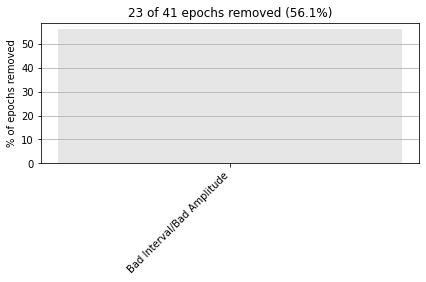

In [ ]:
fig = epochs['error_response'].plot_drop_log()

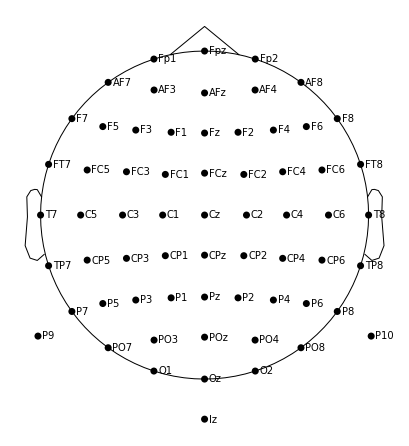

In [ ]:
fig = epochs.plot_sensors(kind='topomap', ch_type='all', show_names=True)

Inspect epochs

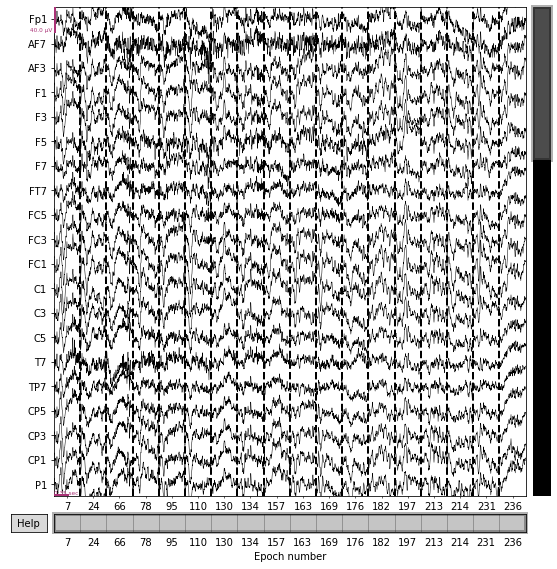

In [ ]:
fig = epochs['error_response'].plot()

combining channels using "mean"
combining channels using "mean"


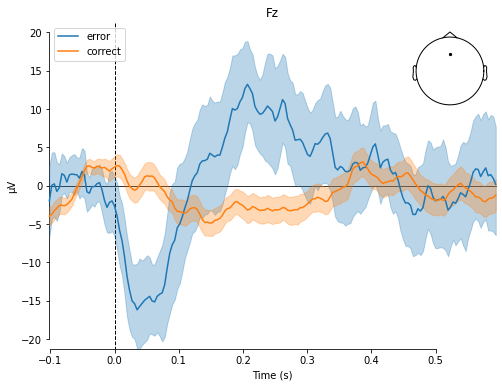

In [ ]:
evokeds = dict(error=list(epochs['error_response'].iter_evoked()),
                correct=list(epochs['correct_response'].iter_evoked()))
picks = ["Fz"]

fig = mne.viz.plot_compare_evokeds(evokeds, combine='mean', picks=picks, ci=0.95)

MNE-Python has a special object for averaged signal called [Evoked](https://mne.tools/stable/generated/mne.Evoked.html#mne-evoked). Evoked objects typically store EEG or MEG signals that have been averaged over multiple epochs, which is a common technique for estimating stimulus-evoked activity (ERPs). Evoked objects can only contain the average of a single set of conditions. Evoked might created by calling `.average()` method on Epoch object.

The data in an Evoked object are stored in an array of shape (`n_channels, n_times)` (in contrast to an Epochs object, which stores data of shape`(n_epochs, n_channels, n_times)`).



In [47]:
# create evoked
error_epochs = epochs['error_response'].average()
correct_epochs = epochs['correct_response'].average()

The information about the signal in Epochs is transferred to derived Evoked objects:

In [48]:
print(error_epochs.info)
print(epochs.info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2017-12-15 10:59:19 UTC
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2017-12-15 10:59:19 UTC
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>


We can visualize the average evoked response for error and correct response using the plot() method, which yields a butterfly plot of each channel type:

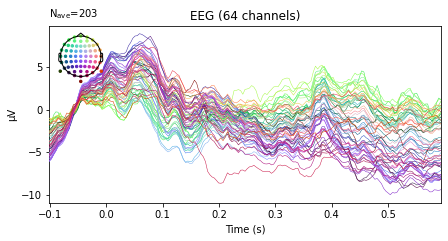

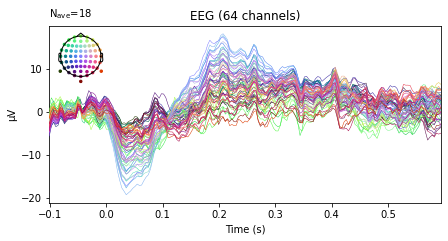

In [49]:
fig1 = correct_epochs.plot(spatial_colors=True)
fig2 = error_epochs.plot(spatial_colors=True)

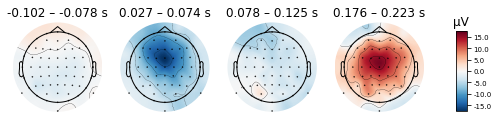

In [ ]:
fig = error_epochs.plot_topomap(times=[-0.1, 0.05, 0.1, 0.2], average=0.05)

No projector specified for this dataset. Please consider the method self.add_proj.


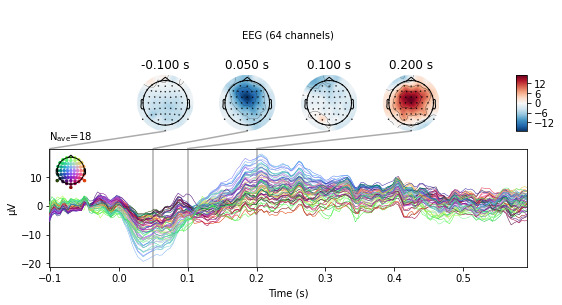

In [ ]:
fig = error_epochs.plot_joint(times=[-0.1, 0.05, 0.1, 0.2])

As with Raw and Epochs objects, Evoked gives a lot of opportunities to work on the signal. For an examples of manipulating and working with Evoked, see the [tutorial](https://mne.tools/stable/auto_tutorials/evoked/10_evoked_overview.html#sphx-glr-auto-tutorials-evoked-10-evoked-overview-py).

---
Let's inspect Evoked from all participants

In [ ]:
# exctract all epochs
epochs = epochs_df.epoch

# average single trials into ERPs (evoked) per condition
evoked_error = [epoch['error_response'].average() for epoch in epochs]
evoked_correct = [epoch['correct_response'].average() for epoch in epochs]

combining channels using "mean"
combining channels using "mean"


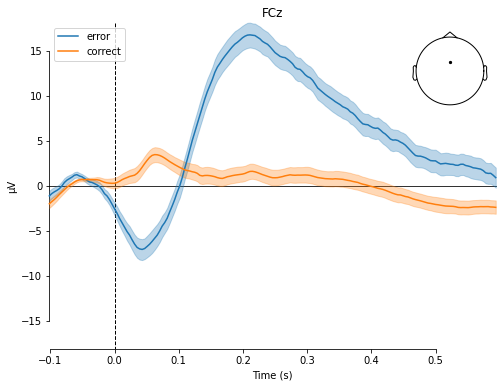

[<Figure size 576x432 with 2 Axes>]

In [ ]:
# plot ERPs from train dataset with 95% CI
evokeds_all = dict(error=evoked_error, correct=evoked_correct)
picks = ['FCz']
mne.viz.plot_compare_evokeds(
    evokeds_all, 
    picks=picks, 
    combine="mean", 
    ci=0.95,
)

---
# Prediction of perfectionism scores from erroneous epochs :)

## Create X and y sets

In [ ]:
epochs_df.isnull().sum()

id                                                    0
epoch                                                 0
Demo_kod                                              1
17-Perfect CM-Concern over Mistakes (9 items mean)    1
17-Perfect PS-Personal Standards (7 items mean)       1
17-Perfect PE-Parental Expectations (5 items mean)    1
17-Perfect PC=Parental Criticism (4 items mean)       1
17-Perfect D=Doubts about Actions (4 items mean)      1
17-Perfect O=Organization (6 items mean)              1
17-Perfectionism full scale (mean)                    1
17-Perfectionism CMDA                                 1
dtype: int64

In [ ]:
epochs_df.fillna(epochs_df.mean(), inplace=True)
epochs_df.isnull().sum()

id                                                    0
epoch                                                 0
Demo_kod                                              1
17-Perfect CM-Concern over Mistakes (9 items mean)    0
17-Perfect PS-Personal Standards (7 items mean)       0
17-Perfect PE-Parental Expectations (5 items mean)    0
17-Perfect PC=Parental Criticism (4 items mean)       0
17-Perfect D=Doubts about Actions (4 items mean)      0
17-Perfect O=Organization (6 items mean)              0
17-Perfectionism full scale (mean)                    0
17-Perfectionism CMDA                                 0
dtype: int64

#### Average errenous responses

In [ ]:
# select epochs from dataframe
epochs_list = epochs_df.epoch.to_list()

# average errorenous responses for each participant
evoked_list = [epoch["error_response"].average() for epoch in epochs_list] 
print(len(evoked_list))

138


#### Get data

In [ ]:
X = np.array([evoked.get_data() for evoked in evoked_list])
y = np.array(epochs_df["17-Perfectionism CMDA"].to_list())
print(X.shape)
print(y.shape)

(138, 64, 179)
(138,)


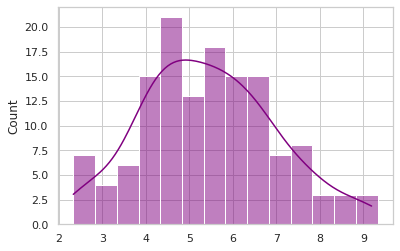

In [ ]:
# inspect perfectionism data distribution
sns.set_theme(style="whitegrid", palette="deep")
fig = sns.histplot(y, binwidth=0.5, kde=True, color="purple")
plt.show()

Not bad!

In [ ]:
# reshape X to (n_samples, f_features)
X = X.reshape(X.shape[0], -1)
print(X.shape)

(138, 11456)


## Fit model

In [ ]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

# create model object
lin_regressor = LinearRegression()

# fit model
lin_regressor.fit(X_train, y_train)

LinearRegression()

## Test model

In [ ]:
# predict perfectionism scores from test epochs
y_pred = lin_regressor.predict(X_test)

print(f"\n ####### Test scores #######\n")

# The coefficient of determination: 1 is perfect prediction
print(f"R2: {r2_score(y_test, y_pred)}")

# The mean absolute error
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# The mean squared error
print(f"MSE: {mean_squared_error(y_test, y_pred)}")


# Check overfitting
print(f"\n ####### Train scores #######\n")
y_train_pred = lin_regressor.predict(X_train)

# The coefficient of determination: 1 is perfect prediction
print(f"Train R2: {r2_score(y_train, y_train_pred)}")


 ####### Test scores #######

R2: -1.0224961141712066
MAE: 1.8481310947737615
MSE: 5.0166370827479465

 ####### Train scores #######

Train R2: 1.0


----
# Tricks and Ideas

In [ ]:
# select epochs from dataframe
epochs_list = epochs_df.epoch.to_list()

# average errorenous responses for each participant
this_evoked_list = [epoch["error_response"].average() for epoch in epochs_list] 

In [ ]:
y = np.array(epochs_df["17-Perfectionism CMDA"].to_list())
print(y.shape)

(138,)


### 1. Pick one (or more) channel

In [ ]:
# remember - always run this cell when performing multiple operations on MNE objects!
evoked_list = copy.deepcopy(this_evoked_list)

In [ ]:
# define list with channels to be picked
picks = ["Fz"]

# picked channel from list of MNE objects (Epochs or Evoked)
evoked_list = [evoked.pick_channels(ch_names=picks, ordered=True) for evoked in evoked_list]
print(evoked_list[0])

<Evoked | 'error_response' (average, N=50), -0.10156 – 0.59375 sec, baseline off, 1 ch, ~37 kB>


In [ ]:
# next - the same ;)
X = np.array([evoked.get_data() for evoked in evoked_list])
print(X.shape)

# reshape X to (n_samples, f_features)
X = X.reshape(X.shape[0], -1)
print(X.shape)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

# create model object
lin_regressor = LinearRegression()

# fit model
lin_regressor.fit(X_train, y_train)

# predict perfectionism scores from test epochs
y_pred = lin_regressor.predict(X_test)

print(f"\n ####### Test scores #######\n")

# The coefficient of determination: 1 is perfect prediction
print(f"R2: {r2_score(y_test, y_pred)}")

# The mean absolute error
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# The mean squared error
print(f"MSE: {mean_squared_error(y_test, y_pred)}")


# Check overfitting
print(f"\n ####### Train scores #######\n")
y_train_pred = lin_regressor.predict(X_train)

# The coefficient of determination: 1 is perfect prediction
print(f"Train R2: {r2_score(y_train, y_train_pred)}")

(138, 1, 179)
(138, 179)

 ####### Test scores #######

R2: -2.1885467588912872
MAE: 2.1120561657000794
MSE: 7.908930849681595

 ####### Train scores #######

Train R2: 1.0


### 2. Trim analysed time-window 

In [ ]:
# remember - always run this cell when performing multiple operations on MNE objects!
evoked_list = copy.deepcopy(this_evoked_list)

In [ ]:
# define min and max range of epochs/evoked in seconds
tmin = 0 
tmax = 0.1

evoked_list = [evoked.crop(tmin=tmin, tmax=tmax) for evoked in evoked_list]

print(evoked_list[0])

<Evoked | 'error_response' (average, N=50), 0 – 0.10156 sec, baseline off, 64 ch, ~110 kB>


In [ ]:
# next - the same ;)
X = np.array([evoked.get_data() for evoked in evoked_list])
print(X.shape)

# reshape X to (n_samples, f_features)
X = X.reshape(X.shape[0], -1)
print(X.shape)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

# create model object
lin_regressor = LinearRegression()

# fit model
lin_regressor.fit(X_train, y_train)

# predict perfectionism scores from test epochs
y_pred = lin_regressor.predict(X_test)

print(f"\n ####### Test scores #######\n")

# The coefficient of determination: 1 is perfect prediction
print(f"R2: {r2_score(y_test, y_pred)}")

# The mean absolute error
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# The mean squared error
print(f"MSE: {mean_squared_error(y_test, y_pred)}")


# Check overfitting
print(f"\n ####### Train scores #######\n")
y_train_pred = lin_regressor.predict(X_train)

# The coefficient of determination: 1 is perfect prediction
print(f"Train R2: {r2_score(y_train, y_train_pred)}")

(138, 64, 27)
(138, 1728)

 ####### Test scores #######

R2: -1.528307113970266
MAE: 2.193045396305889
MSE: 6.271260120426116

 ####### Train scores #######

Train R2: 1.0


# TODO 🔥

Another good idea it to average signal in selected time-window. It's usual way the ERPs are analysed.

Let's try combining two previous tips/ideas into following pipeline:
* Select one channel (e.g. Fz)
* Select time-window 0 to 100ms (usual time-window for ERN)
* Average signal in selected window.

Remember, that X has shape: `(n_samples, n_channels, n_timepoints)` - you may check it with `print(X.shape)`. It means that if you select one channel, your X dataset shape will be like: `(101, 1, n_timepoints)`. To average signal in time-window for each channel we have to average datapoints from the last dimension of an X array. Use [`np.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) method with appropriate axis argument.



### 3. Average ERPs in selected time-window 

In [ ]:
# remember - always run this cell when performing multiple operations on MNE objects!
evoked_list = copy.deepcopy(this_evoked_list)

In [ ]:
# select one channel

## your code goes here...

In [ ]:
# select time window

## your code goes here...

In [ ]:
# select data from MNE Evoked with get_data() method

## your code goes here...

# and average signal 

## your code goes here...

In [ ]:
# next - the same ;)

# reshape X to (n_samples, f_features)
X = X.reshape(X.shape[0], -1)
print(X.shape)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

# create model object
lin_regressor = LinearRegression()

# fit model
lin_regressor.fit(X_train, y_train)

# predict perfectionism scores from test epochs
y_pred = lin_regressor.predict(X_test)

print(f"\n ####### Test scores #######\n")

# The coefficient of determination: 1 is perfect prediction
print(f"R2: {r2_score(y_test, y_pred)}")

# The mean absolute error
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

# The mean squared error
print(f"MSE: {mean_squared_error(y_test, y_pred)}")


# Check overfitting
print(f"\n ####### Train scores #######\n")
y_train_pred = lin_regressor.predict(X_train)

# The coefficient of determination: 1 is perfect prediction
print(f"Train R2: {r2_score(y_train, y_train_pred)}")

Note, that now our feature vector is a 1D array - we can visualize the relationsip between perfectionism data and ERN.

In [ ]:
prediction_results_df = pd.DataFrame({ 
    "X_test": X_test.reshape(-1),
    "y_real": y_test,
    "y_pred": y_pred,   
})

In [ ]:
# set seaborn theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,9))

# draw lineplot for predicted data 
s = sns.lineplot(data=prediction_results_df, x="X_test", y="y_pred", color="purple")

# draw observed (real) data as point plot
sns.scatterplot(data=prediction_results_df, x="X_test", y="y_real", color="pink")

# add legend to the plot
plt.legend(labels=["Regression line","Observed data"])

# change axes labels
s.set( xlabel = "Mean ERN", ylabel = "Perfectionism scores")

plt.plot()

And check how the prediction line look like on whole dataset:

In [ ]:
# We use our trained linear regressor to predict on the whole dataset:
y_pred_full = lin_regressor.predict(X)

In [ ]:
prediction_results_full_df = pd.DataFrame({ 
    "X": X.reshape(-1),
    "y_real": y,
    "y_pred": y_pred_full,   
})

In [ ]:
# set seaborn theme
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,9))

# draw lineplot for predicted data 
s = sns.lineplot(data=prediction_results_full_df, x="X", y="y_pred", color="purple")

# draw observed (real) data as point plot
sns.scatterplot(data=prediction_results_full_df, x="X", y="y_real", color="pink")

# add legend to the plot
plt.legend(labels=["Regression line","Observed data"])

# change axes labels
s.set( xlabel = "Mean ERN", ylabel = "Perfectionism scores")

plt.plot()

And this is the end ;) 


We created a simple linear model that *relatively*  confirms our hypothesis that there is a relationship between perfectionism and error-related negativity. The greater magnitude of the ERN, the higher the perfectionism score. 🎈